<a href="https://colab.research.google.com/github/sv650s/sb-capstone/blob/master/2019_07_25_biGRU_2layer_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRU Prototype With Attention

Previous notebook we implemented a [single layer GRU](https://github.com/sv650s/sb-capstone/blob/master/2019-07-22-GRU_prototype.ipynb) without attention

For this notebook, we will implement a 2 layer GRU network with attention and 3 dense layer architecture


As before, I am using some utility functions so I don't have copy so much code around. Source code for the modules are here:
* [dict_util](https://github.com/sv650s/sb-capstone/blob/master/util/dict_util.py)
* [plot_util](https://github.com/sv650s/sb-capstone/blob/master/util/plot_util.py)
* [keras_util](https://github.com/sv650s/sb-capstone/blob/master/util/keras_util.py)
* [file_util](https://github.com/sv650s/sb-capstone/blob/master/util/file_util.py)

In [8]:
from google.colab import drive
import sys
drive.mount('/content/drive')
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
# add this to sys patch so we can import utility functions
sys.path.append(DRIVE_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GRU, Dropout, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pickle
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import os
import seaborn as sns
import matplotlib.pyplot as plt


# custom utility functions
import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku


sns.set()


In [0]:
DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-preprocessed-110k.csv"
LABEL_COLUMN = "star_rating"
FEATURE_COLUMN = "review_body"




In [11]:
import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
df = pd.read_csv(f"{DATA_FILE}")

## Preprocessing

*  Preprocessing data file and create the right inputs for Keras models
     *   Features:
        * tokenize
        * pad features into sequence
     *   Labels:
       *  one hot encoder
* split between training and testing

See [keras_util](https://github.com/sv650s/sb-capstone/blob/master/util/keras_util.py) for souce code

In [13]:
X_train, X_test, y_train, y_test, tokenizer, max_sequence_length = \
                                  ku.preprocess_file(data_df=df, 
                                                      feature_column=FEATURE_COLUMN, 
                                                      label_column=LABEL_COLUMN, 
                                                      keep_percentile=0.99)

One hot enocde label data...
Splitting data into training and test sets...


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Vocabulary size=40788
Number of Documents=84032
Max Sequence Length: 186


# Building Our GRU Model

In [0]:
from keras.engine.topology import Layer
from keras import backend as K
import keras


class AttentionLayer(Layer):
    
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        """
        
        self.supports_masking = True
        self.init = keras.initializers.get('glorot_uniform')

        self.W_regularizer = keras.regularizers.get(W_regularizer)
        self.b_regularizer = keras.regularizers.get(b_regularizer)

        self.W_constraint = keras.constraints.get(W_constraint)
        self.b_constraint = keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)
        

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True
        

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    
    def call(self, x, mask=None):
        # TF backend doesn't support it
        # eij = K.dot(x, self.W) 
        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), 
                              K.reshape(self.W, (features_dim, 1))),
                        (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        
        return K.sum(weighted_input, axis=1)

    
    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    
    
    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
MODEL_NAME = "GRU_bi2layer_attention"
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128
VOCAB_SIZE = len(tokenizer.word_counts)+1
GRU_DIM = 250 # total GRU units

In [0]:
from keras.layers import CuDNNGRU

model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=max_sequence_length))
model.add(Bidirectional(CuDNNGRU(GRU_DIM*2, return_sequences=True)))
model.add(Bidirectional(CuDNNGRU(GRU_DIM, return_sequences=True)))
model.add(AttentionLayer(max_sequence_length))
# model.add(Bidirectional(GRU(units=GRU_DIM, 
#                             activation='tanh', 
#                             use_bias=True, 
#                             dropout=0.2, 
#                             recurrent_dropout=0.2)))
model.add(Dense(GRU_DIM*2, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(GRU_DIM, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])


In [39]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 186, 300)          12236700  
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 186, 1000)         2406000   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 186, 500)          1878000   
_________________________________________________________________
attention_layer_8 (Attention (None, 500)               686       
_________________________________________________________________
dense_10 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 250)               125250    
__________

In [40]:
# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.4,
                              patience=2, 
                              min_lr=0.00001,
                             mode='auto')
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           mode='auto', 
                           verbose=1,
                          restore_best_weights=True)
network_history = model.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[reduce_lr, early_stop])

Train on 67225 samples, validate on 16807 samples
Epoch 1/50
67225/67225 [==============================] - 161s 2ms/step - loss: 0.9728 - acc: 0.6305 - val_loss: 0.8506 - val_acc: 0.6697
Epoch 2/50
67225/67225 [==============================] - 158s 2ms/step - loss: 0.7761 - acc: 0.6960 - val_loss: 0.8435 - val_acc: 0.6722
Epoch 3/50
67225/67225 [==============================] - 158s 2ms/step - loss: 0.6855 - acc: 0.7340 - val_loss: 0.8584 - val_acc: 0.6630
Epoch 4/50
67225/67225 [==============================] - 159s 2ms/step - loss: 0.6049 - acc: 0.7696 - val_loss: 0.8914 - val_acc: 0.6689
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


## Evaluating the Model

In [57]:
from util.keras_util import ModelEvaluator

me = ModelEvaluator(MODEL_NAME, model, network_history)
me.evaluate(X_test, y_test)

Running model.evaluate...
28011/28011 [==============================] - 35s 1ms/step
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...


In [58]:
print("Accuracy: %.2f%%" % (me.scores[1]*100))


Accuracy: 67.83%


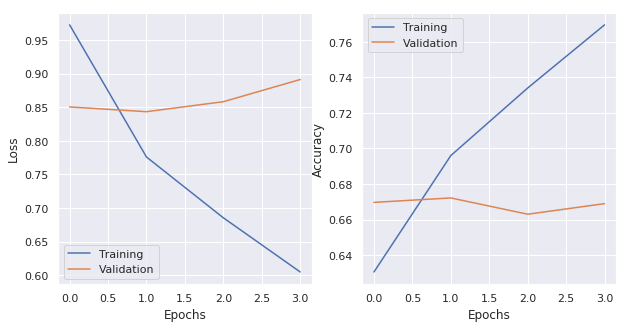

In [59]:
pu.plot_network_history(me.network_history)

In [60]:
me.confusion_matrix

array([[ 3099,   132,   359,    98,   280],
       [  777,   157,   415,   255,   267],
       [  419,    80,   552,   798,   682],
       [  122,    23,   216,  1280,  3111],
       [  194,    15,    90,   678, 13912]])

In [61]:
print(me.classification_report)

              precision    recall  f1-score   support

           1       0.67      0.78      0.72      3968
           2       0.39      0.08      0.14      1871
           3       0.34      0.22      0.27      2531
           4       0.41      0.27      0.33      4752
           5       0.76      0.93      0.84     14889

    accuracy                           0.68     28011
   macro avg       0.51      0.46      0.46     28011
weighted avg       0.63      0.68      0.64     28011



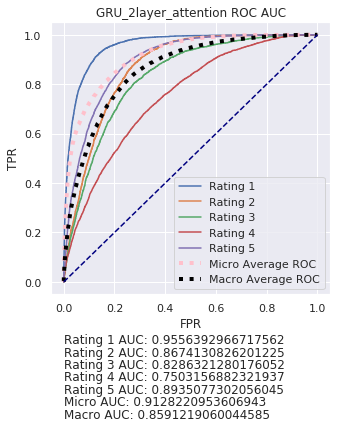

In [62]:
fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(me.name, me.roc_auc, me.fpr, me.tpr)

## Save off filees

In [0]:
directory, INBASENAME = fu.get_dir_basename(DATA_FILE)
DESCRIPTION = f"{INBASENAME}-{MODEL_NAME}-{max_sequence_length}-{FEATURE_COLUMN}"
MODEL_FILE = f"{DRIVE_DIR}/models/{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}.h5"
NETWORK_HISTORY_FILE = f'{DRIVE_DIR}/models/{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}-history.pkl'
REPORT_FILE = f"{DRIVE_DIR}/reports/{datetime.now().strftime(DATE_FORMAT)}-dl_protype-report.csv"
TOKENIZER_FILE = f'{DRIVE_DIR}/models/dl-tokenizer.pkl'


In [0]:
me.model.save(MODEL_FILE)

In [0]:
pickle.dump(me.network_history, open(NETWORK_HISTORY_FILE, "wb"))
pickle.dump(tokenizer, open(TOKENIZER_FILE, "wb"))

In [0]:
# saving off report in the same format as other report just in case we want to compare for later
flattened = {}
flattened = du.add_dict_to_dict(flattened, me.crd)
flattened = du.add_dict_to_dict(flattened, me.roc_auc)
flattened["tpr"] = me.tpr
flattened["fpr"] = me.fpr
flattened["loss"] = me.scores[0]
flattened["accuracy"] = me.scores[1]
flattened["confusion_matrix"] = me.confusion_matrix
flattened["description"] = DESCRIPTION
flattened["file"] = DATA_FILE
flattened["network_history_file"] = NETWORK_HISTORY_FILE
flattened["tokenizer_file"] = TOKENIZER_FILE
flattened["max_sequence_length"] = max_sequence_length
flattened["embedding"] = EMBED_SIZE
flattened["model_file"] = MODEL_FILE
flattened["model_name"] = MODEL_NAME
flattened["test_examples"] = X_test.shape[0]
flattened["test_features"] = X_test.shape[1]
flattened["train_examples"] = X_train.shape[0]
flattened["train_features"] = X_train.shape[1]
flattened["status"] = "success"
flattened["status_date"] = datetime.now().strftime(TIME_FORMAT)


In [135]:
# check to see if report file exisits, if so load it and append
print(f'Loading {REPORT_FILE}')
exists = os.path.isfile(REPORT_FILE)
if exists:
    report_df = pd.read_csv(REPORT_FILE)
else:
    report_df = pd.DataFrame()
    
report_df = report_df.append(flattened, ignore_index=True)
report_df.head(20)

Loading drive/My Drive/Springboard/capstone/reports/2019-07-26-dl_protype-report.csv


,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,3_recall,3_support,4_f1-score,4_precision,4_recall,4_support,5_f1-score,5_precision,5_recall,5_support,accuracy,auc_1,auc_2,auc_3,auc_4,auc_5,auc_macro,auc_micro,confusion_matrix,description,embedding,file,fpr,loss,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,max_sequence_length,model_file,model_name,network_history_file,status,status_date,test_examples,test_features,tokenizer_file,tpr,train_examples,train_features,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support
0,0.699892,0.668502,0.734375,3968,0.208247,0.291627,0.161945,1871,0.309842,0.317823,0.302252,2531,0.349922,0.409360,0.305556,4752,0.826930,0.783000,0.876083,14889,0.659669,0.944717,0.847903,0.809665,0.731212,0.872641,0.841251,0.899640,[[ 2914 352 369 86 247]\n [ 721 30...,amazon_reviews_us_Wireless_v1_00-preprocessed-...,300,drive/My Drive/Springboard/capstone/data/amazo...,"{0: array([0. , 0. , 0. , .....",1.011368,0.478967,0.494062,0.476042,28011,186,drive/My Drive/Springboard/capstone/models/201...,CNN_3layer_with_pooling_early_stop,drive/My Drive/Springboard/capstone/models/201...,success,7/25/19 18:13,28011,186,drive/My Drive/Springboard/capstone/models/201...,"{0: array([0.00000000e+00, 2.52016129e-04, 2.2...",84032,186,0.639963,0.628540,0.659669,28011
1,0.585552,0.613875,0.559728,3968,0.237802,0.228868,0.247461,1871,0.260959,0.272337,0.250494,2531,0.316089,0.344682,0.291877,4752,0.780017,0.752528,0.809591,14889,0.598301,0.859891,0.741051,0.701313,0.653234,0.813515,0.753827,0.827750,[[ 2221 734 346 122 545]\n [ 534 46...,amazon_reviews_us_Wireless_v1_00-preprocessed-...,300,drive/My Drive/Springboard/capstone/data/amazo...,"{0: array([0. , 0.00141413, 0.00191324,...",2.646713,0.436084,0.442458,0.431830,28011,186,drive/My Drive/Springboard/capstone/models/201...,CNN_3layer_with_pooling_15_epoch,drive/My Drive/Springboard/capstone/models/201...,success,7/25/19 19:46,28011,186,drive/My Drive/Springboard/capstone/models/201...,"{0: array([0. , 0.08341734, 0.09299395,...",84032,186,0.590647,0.585330,0.598301,28011
2,0.699142,0.647615,0.759577,3968,0.217936,0.273387,0.181187,1871,0.288655,0.332817,0.254840,2531,0.313079,0.403183,0.255892,4752,0.826345,0.771602,0.889449,14889,0.658920,0.941683,0.843724,0.806022,0.726704,0.871740,0.837998,0.899241,[[ 3014 371 230 81 272]\n [ 805 33...,amazon_reviews_us_Wireless_v1_00-preprocessed-...,32,drive/My Drive/Springboard/capstone/data/amazo...,"{0: array([0. , 0. , 0. ,...",0.994809,0.469031,0.485721,0.468189,28011,186,drive/My Drive/Springboard/capstone/models/201...,CNN_1layerEmbedding32,drive/My Drive/Springboard/capstone/models/201...,success,7/24/19 5:28,28011,186,drive/My Drive/Springboard/capstone/models/201...,"{0: array([0.00000000e+00, 2.52016129e-04, 7.5...",84032,186,0.632028,0.618611,0.658920,28011
3,0.696838,0.668597,0.727571,3968,0.197038,0.277132,0.152859,1871,0.324192,0.308987,0.340972,2531,0.350047,0.392521,0.315867,4752,0.814664,0.785340,0.846262,14889,0.647496,0.947877,0.851681,0.808577,0.728379,0.871871,0.841699,0.898781,[[ 2887 355 413 73 240]\n [ 725 28...,amazon_reviews_us_Wireless_v1_00-preprocessed-...,300,drive/My Drive/Springboard/capstone/data/amazo...,"{0: array([0. , 0. , 0. ,...",0.964895,0.476556,0.486515,0.476706,28011,186,2019-07-24-amazon_reviews_us_Wireless_v1_00-pr...,CNN_1layerEmbedding300,2019-07-24-amazon_reviews_us_Wireless_v1_00-pr...,success,7/24/19 5:30,28011,186,2019-07-24-amazon_reviews_us_Wireless_v1_00-pr...,"{0: array([0.00000000e+00, 2.52016129e-04, 8.5...",84032,186,0.633579,0.625174,0.647496,28011
4,0.713225,0.660791,0.774698,3968,0.169296,0.302198,0.117584,1871,0.308936,0.345552,0.279336,2531,0.303829,0.436686,0.232955,4752,0.831112,0.758338,0.919336,14889,0.671022,0.948909,0.853113,0.813873,0.740059,0.877310,0.846676,0.906195,[[ 3074 203 268 52 371]\n [ 845 22...,amazon_reviews_us_Wireless_v1_00-preproc

In [0]:
report_df.to_csv(REPORT_FILE, index=False)

# Compare 2 Layeer GRU with Attention to 1 Layer GRU without Attention

In [136]:
# let's see all the model repoorts that we saved off from before
report_df.model_name

0    CNN_3layer_with_pooling_early_stop
1      CNN_3layer_with_pooling_15_epoch
2                 CNN_1layerEmbedding32
3                CNN_1layerEmbedding300
4                            CNN_2layer
5                            CNN_3layer
6                            GRU_1layer
7                GRU_bi1layer_attention
8                GRU_bi2layer_attention
Name: model_name, dtype: object

In [0]:
display_df = report_df[report_df.model_name.str.startswith("GRU")]

In [140]:
display_df[["model_name", "accuracy"]].T

,6,7,8
model_name,GRU_1layer,GRU_bi1layer_attention,GRU_bi2layer_attention
accuracy,0.668844,0.67727,0.678305


In [141]:
for index, row in display_df.iterrows():
  print(f'Confusion Matrix - {row.model_name}:\n{row.confusion_matrix}\n')


Confusion Matrix - GRU_1layer:
[[ 3110   206   255    95   302]
 [  836   194   376   191   274]
 [  456   197   624   574   680]
 [  158    67   365  1388  2774]
 [  225    42   180  1023 13419]]

Confusion Matrix - GRU_bi1layer_attention:
[[ 3017   310   278    45   318]
 [  762   292   450   117   250]
 [  416   231   858   420   606]
 [  130    80   551  1069  2922]
 [  174    45   254   681 13735]]

Confusion Matrix - GRU_bi2layer_attention:
[[ 3099   132   359    98   280]
 [  777   157   415   255   267]
 [  419    80   552   798   682]
 [  122    23   216  1280  3111]
 [  194    15    90   678 13912]]



In [142]:
cr_columns = sorted([col for col in display_df.columns if col[0].isdigit()])
cr_columns.insert(0, "model_name")
display_df[cr_columns].T


,6,7,8
model_name,GRU_1layer,GRU_bi1layer_attention,GRU_bi2layer_attention
1_f1-score,0.710614,0.712649,0.722462
1_precision,0.649948,0.670593,0.672088
1_recall,0.78377,0.760333,0.780998
1_support,3968,3968,3968
2_f1-score,0.150563,0.206433,0.13784
2_precision,0.274788,0.304802,0.385749
2_recall,0.103688,0.156066,0.0839123
2_support,1871,1871,1871
3_f1-score,0.288155,0.348639,0.265193


In [143]:
auc_columns = sorted([col for col in display_df.columns if col.startswith('auc')])
auc_columns.insert(0, "model_name")
display_df[auc_columns].T


,6,7,8
model_name,GRU_1layer,GRU_bi1layer_attention,GRU_bi2layer_attention
auc_1,0.948884,0.953787,0.955639
auc_2,0.855739,0.862784,0.867413
auc_3,0.818787,0.833407,0.828632
auc_4,0.740204,0.754537,0.750316
auc_5,0.878942,0.892991,0.893508
auc_macro,0.848532,0.859522,0.859122
auc_micro,0.906253,0.912754,0.912822


# Conclusion

Generally we are seeing the 2 Layer GRU Attention is performing better than 1 Layer GRU with and without Attention

* Accuracy increased by overall 1% when we implemented the 2 layer bidirecitonal GRU with attention compared to 1 layer without attention and only slightly better than 1 layer with Attentiion
* 1 layer GRU with attention identified the most number of Star 2 ratings which has the highest recall however, the precision is not as high as 2 layer with attention 
* 2 layer GRU with attention classifies star 2 ratings less but they tend to be more accurate - precision increased by around 10% from 1 layer without attention. Although since we are now less likely to classify something as star 2 rating, the recall has dropped by a couple perent - I think this is a reasonable trade-off
* 1 layer GRU with attentions did the best for Star rating 3 where as 2 layer GRU with attention did the worse for this class
* Both models with attention, recall was worse than 1 layer without attention meaning they tended not to classify reviews at star 4. However, 1 layer GRU with attention was the most accurate when it did classify a review into this class
* AUC for 2 layer with attention did better than the other 2 models except it did slightly worse 0.4% than 1 layer with attention

Overall, I would choose 2 layer GRU with attention over the other 2 models as it performs better in star rating 2 with small tradeoffs in class 4 ratings